## Заработная плата в России 
##### Необходимо проанализировать данные о заработной плате за каждый месяц с января 1993 по август 2016, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [1]:
import pandas as pd
import math as m
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product
%pylab inline

/home/vladimir/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


/home/vladimir/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
salary = pd.read_csv("WAG_C_M.csv",sep =';', index_col=['month'], parse_dates=['month'], dayfirst=True)
salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


Text(0.5,0,'quarters')

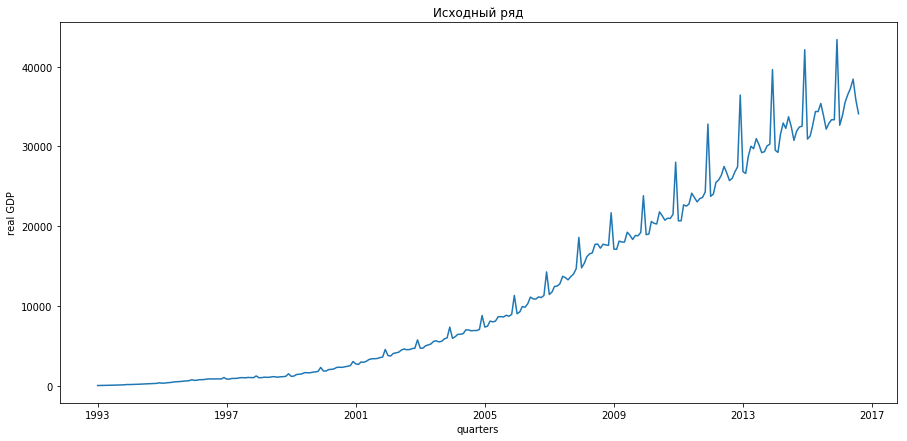

In [3]:
#Расмотрим исходный ряд
plt.figure(figsize(15,7))
plt.plot(salary.WAG_C_M)
plt.title('Исходный ряд')
plt.ylabel('real GDP')
plt.xlabel('quarters')

In [4]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

Критерий Дики-Фуллера: p=0.991850


Попытаемся Стабилизировать дисперсию с помощью преобразования Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


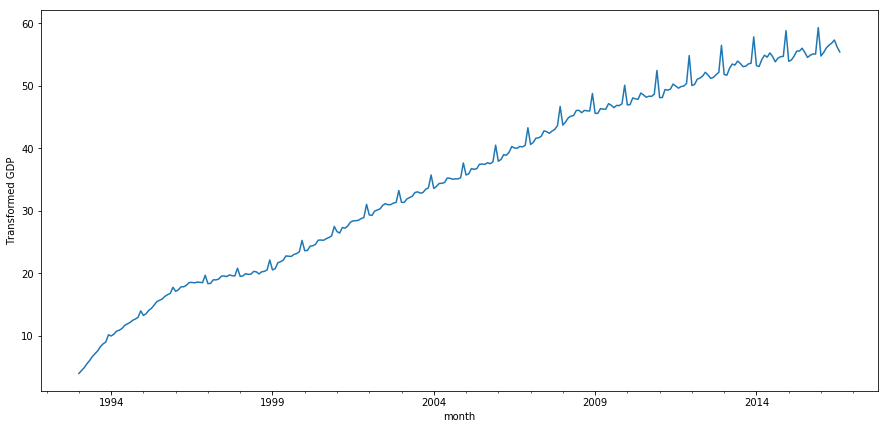

In [5]:
salary['salary_box'] , lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.salary_box.plot()
plt.ylabel(u'Transformed GDP')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box)[1])

Попытаемся Сделать ряд стационарным с помощью сезонного дифференцирования

Критерий Дики-Фуллера: p=0.014697


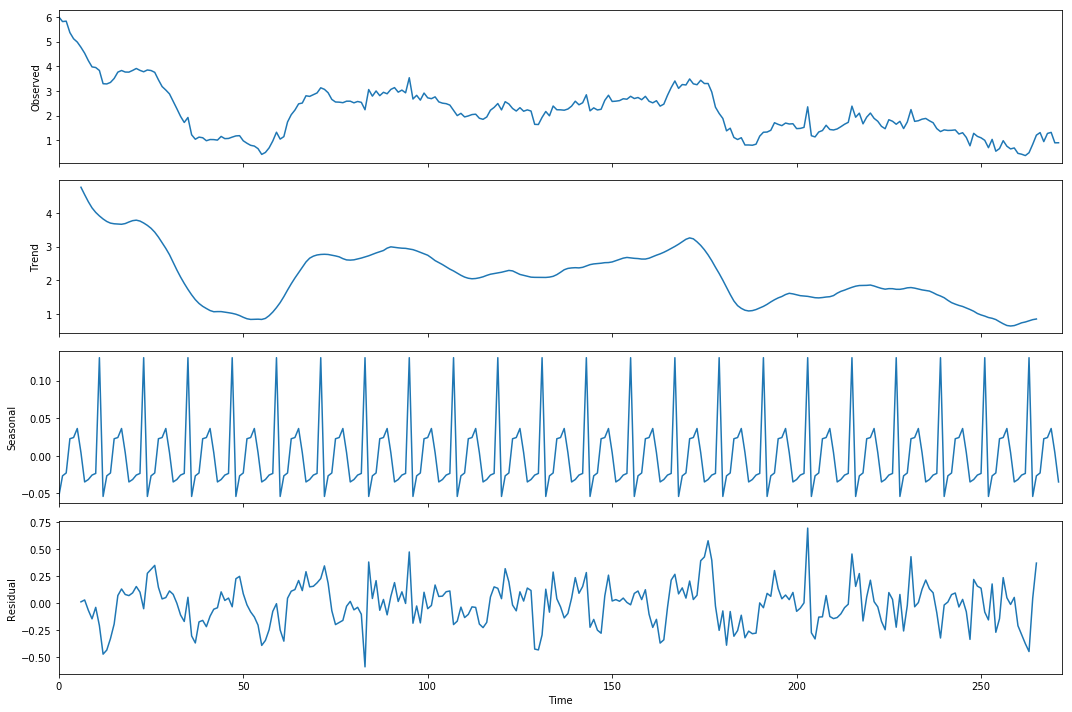

In [6]:
salary['salary_box_diff'] = salary.salary_box - salary.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff.values[12:], freq=12).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff.values[12:])[1])

Гипотиза нестационарности отвергается, но по графику видно что ряд остался нестационарным. Попробуем обычное дифференцирование.

Критерий Дики-Фуллера: p=0.000000


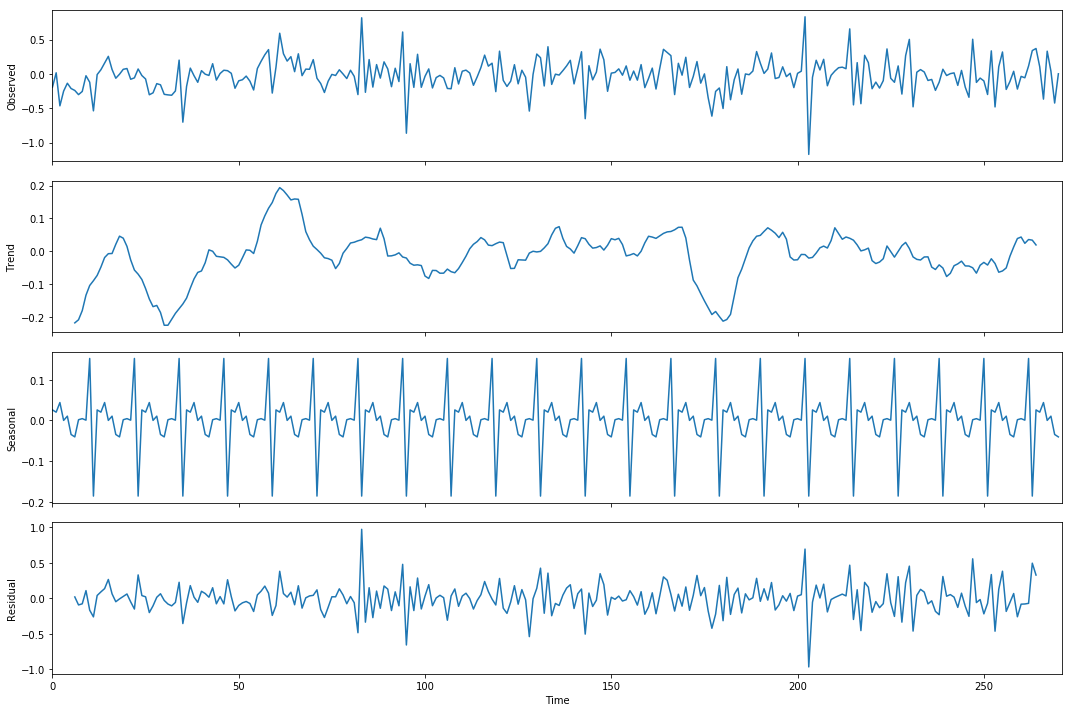

In [7]:
salary['salary_box_diff2'] = salary.salary_box_diff - salary.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff2.values[13:], freq=12).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff2.values[13:])[1])

Гипотеза нестационарности уверенно отвергается, и визуально ряд выглядит лучше — тренда больше нет

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

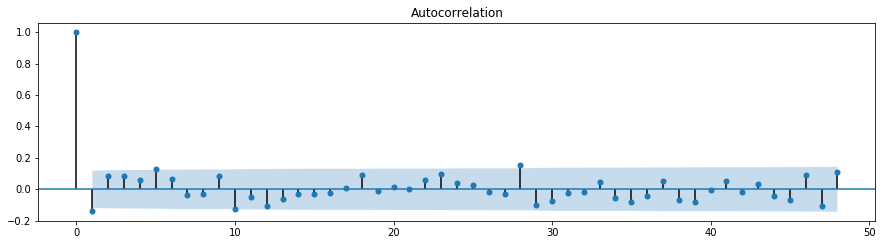

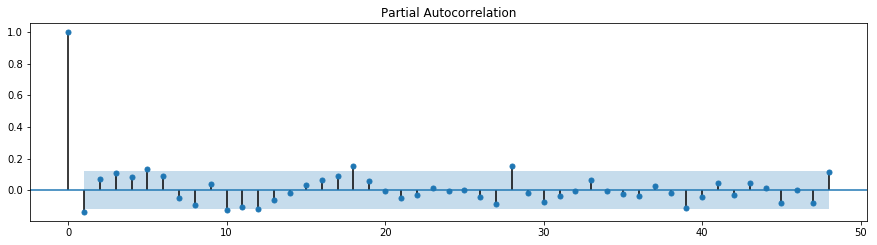

In [8]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff2.values[13:], lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff2.values[13:], lags=48, ax=ax)
pylab.show()

Из графика автокорреляции можем приблизительно подобрать параметры Q, q - последние значимые сезонный и несезонный лаги соответсвенно. Возьмем Q = 0, q = 5 (<12) 
Из графика частичной автокорреляции можем приблизительно подобрать параметры P, p - последние значимые сезонный и несезонный лаги соответсвенно. Поэтому P = 1, p = 10 (<12) 

In [10]:
from itertools import product
ps = range(0, 11)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs = range(0, 1)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

132

Обучаем модель

In [11]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box.values, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (4, 4, 1, 0)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 2, 1, 0)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 3, 1, 0)
wrong parameters: (5, 4, 0, 0)
wrong parameters: (5, 4, 1, 0)
wrong parameters: (6, 3, 0, 0)
wrong parameters: (6, 3, 1, 0)
wrong parameters: (6, 4, 0, 0)
wrong parameters: (6, 4, 1, 0)
wrong parameters: (7, 3, 0, 0)
wrong parameters: (7, 3, 1, 0)
wrong parameters: (7, 4, 0, 0)
wrong parameters: (7, 4, 1, 0)
wrong parameters: (8, 4, 0, 0)
wrong parameters: (8, 4, 1, 0)
wrong parameters: (8, 5, 0, 0)
wrong parameters: (8, 5, 1, 0)
wrong parameters: (9, 4, 0, 0)
wrong pa

In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic').head(10))

       parameters        aic
52   (5, 5, 1, 0) -25.925198
60   (6, 5, 1, 0) -23.963134
51   (5, 5, 0, 0) -23.081042
59   (6, 5, 0, 0) -20.711420
91  (10, 3, 0, 0) -16.595532
20   (1, 5, 1, 0) -15.867145
68   (7, 5, 1, 0) -15.523426
37   (3, 5, 0, 0) -15.251013
38   (3, 5, 1, 0) -15.099643
28   (2, 5, 1, 0) -13.907140


In [13]:
#рассмотрим лучшую модель
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.963
Date:                            Mon, 26 Mar 2018   AIC                            -25.925
Time:                                    00:08:45   BIC                             17.862
Sample:                                         0   HQIC                            -8.370
                                            - 284                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0205      7.792      0.003      0.998     -15.252      15.293
ar.L2          0.0076      5.254   

Рассмотрим остатки модели

Критерий Стьюдента: p=0.173242
Критерий Дики-Фуллера: p=0.000000


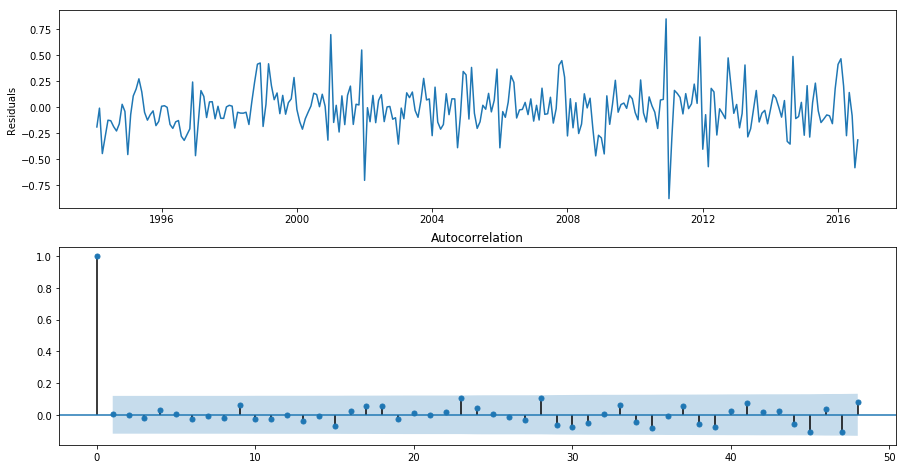

In [14]:
plt.figure(figsize(15,8))
plt.subplot(211)
plt.plot(salary.index.values[13:], best_model.resid[13:])
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:], lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Стьюдента: p=0.168543 - остатки несмещены
Критерий Дики-Фуллера: p=0.000000 - остатки стационарны (+ видно из графика)
Критерий Льюнга-Бокса и коррелограмма подтверждает неавтокоррелированность (значимых лагов нет)

In [15]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Посмотрим, как модельподстроилась под данные

In [16]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)

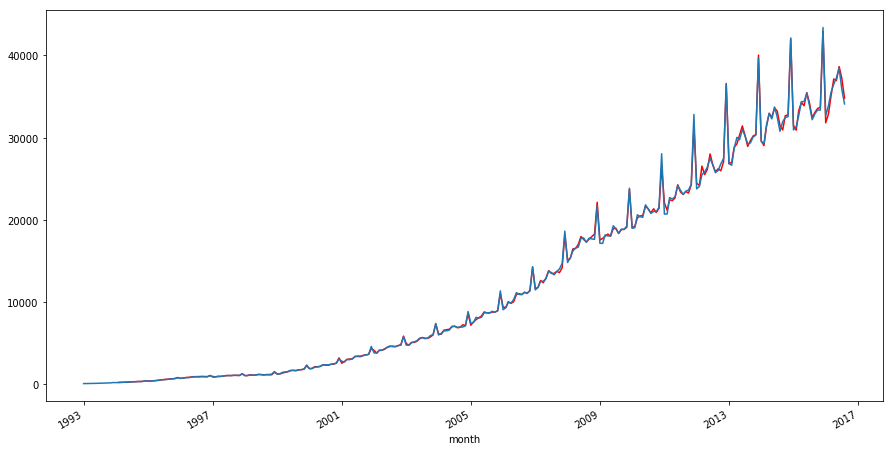

In [17]:
plt.plot(salary.index.values[13:], salary.model.values[13:], color='r')
salary.WAG_C_M.plot()

Визуально, модель хорошо описывает данные

### Прогноз

In [18]:
salary.index[-1]

Timestamp('2016-08-01 00:00:00')

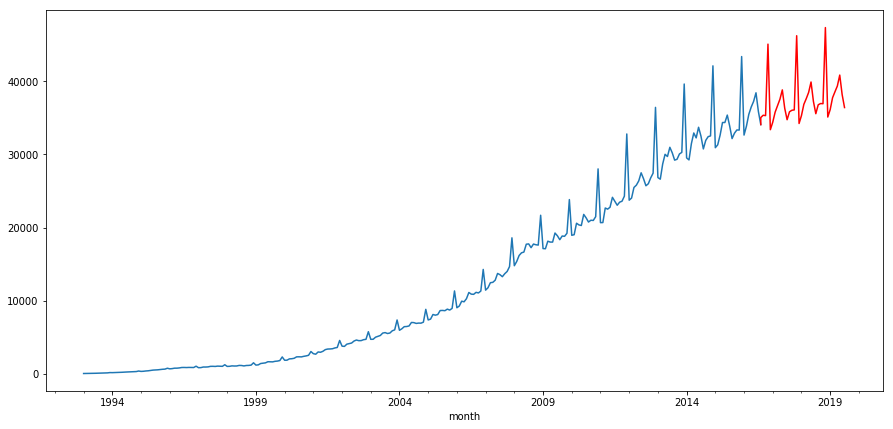

In [19]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
start = len(best_model.fittedvalues)
future.WAG_C_M = invboxcox( best_model.predict(start=start, end=start+35), lmbda)
salary2 = pd.concat([salary2, future])


plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary2.WAG_C_M["2016-08-01":].plot(color='r')
pylab.show()

На вид предсказания кажутся адекватными